# Final

> The take-home part of the final.

In [1]:
#hide
from nbdev.showdoc import *

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from statsmodels.formula.api import logit

***Load Data***

Graduate school admission data (binary series):    
https://www.kaggle.com/malapatiravi/graduate-school-admission-data/home

In [3]:
df = pd.read_csv("../data/final/admission.csv")
print(df)

     admit  gre   gpa  rank
0        0  380  3.61     3
1        1  660  3.67     3
2        1  800  4.00     1
3        1  640  3.19     4
4        0  520  2.93     4
..     ...  ...   ...   ...
395      0  620  4.00     2
396      0  560  3.04     3
397      0  460  2.63     2
398      0  700  3.65     2
399      0  600  3.89     3

[400 rows x 4 columns]


In [4]:
df.describe()

admit         gre         gpa       rank
count  400.000000  400.000000  400.000000  400.00000
mean     0.317500  587.700000    3.389900    2.48500
std      0.466087  115.516536    0.380567    0.94446
min      0.000000  220.000000    2.260000    1.00000
25%      0.000000  520.000000    3.130000    2.00000
50%      0.000000  580.000000    3.395000    2.00000
75%      1.000000  660.000000    3.670000    3.00000
max      1.000000  800.000000    4.000000    4.00000

***Preprocessing***  
Shuffle data and train/test split

In [5]:
# Shuffle in place
df = df.sample(frac=1).reset_index(drop=True)

# 80% of training, 20% of testing
df_train = df.iloc[:int(df.shape[0]*0.8), :]
df_test = df.iloc[int(df.shape[0]*0.8):, :]

print("Number of training:", df_train.shape[0])
print("Number of testing:", df_test.shape[0])

Number of training: 320
Number of testing: 80


# Question 1

Briefly describe the series.  What transformations would you like to do before beginning to forecast the series (note: you do not have to do these, especially if they require obtaining additional series)?

The graduate school admission data is a binary series. It has 400 instances, each with 3 attributes and a target. The target, which is the decision of admission, is expressed as 0 or 1. The other attributes are GRE, GPA, and school rank. The main task here is to fit a model in order to predict the admission decision according to GRE, GPA, and school rank.

Transformations might not be required for this dataset. It's possible that some GRE tests are slightly easier or harder than others. Potentially, we can adjust the GRE scores. However, that requires additional data that indicate the difficulty of different GRE tests. I am not sure whether that data is publicly available. However, a general assumption is that the difficulty of tests won't be too drastically different.

# Question 2

Looking at your data, does it seem to have a trend, seasonal, and/or cyclical component(s)?

Because of the nature of the binary series, I don't see a trend, seasonal, or cyclical components.

I plotted GRE, GPA, and school rank individually against the admission decision in the plot below. It looks like the scatter points for acceptance tend to cluster around higher GRE or GPA.

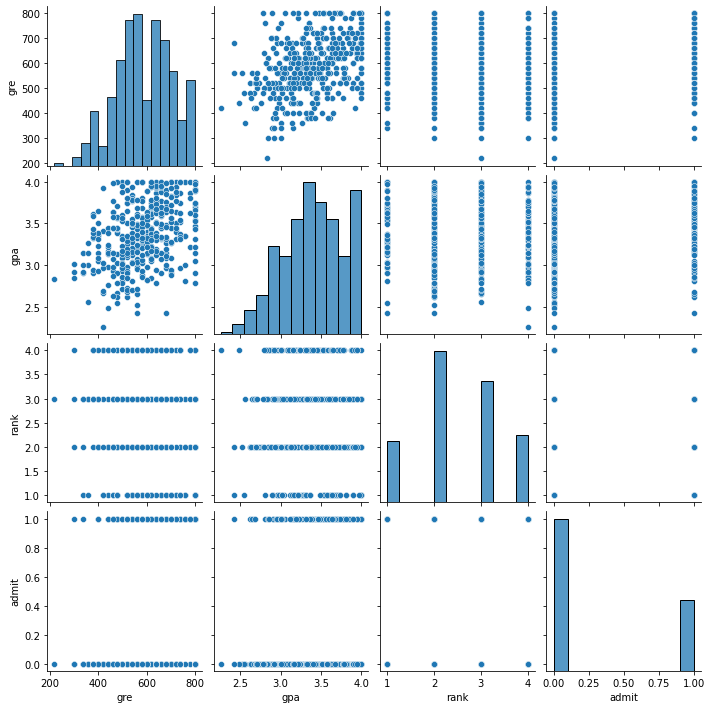

In [6]:
sns.pairplot(df, vars = ['gre', 'gpa', 'rank', 'admit'])

# Question 3

If you choose to work on a binary series, you can use only logistic regression, you do not have to use other methods. In this case answer the following:

In [8]:
formula = "admit ~ gpa + gre + C(rank)"
logit_model = logit(formula, data = df_train)
logit_estimates = logit_model.fit()

print(logit_estimates.summary())

Optimization terminated successfully.
         Current function value: 0.580803
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  320
Model:                          Logit   Df Residuals:                      314
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 May 2021   Pseudo R-squ.:                 0.07894
Time:                        15:26:45   Log-Likelihood:                -185.86
converged:                       True   LL-Null:                       -201.79
Covariance Type:            nonrobust   LLR p-value:                 6.338e-06
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.7366      1.232     -3.032      0.002      -6.152      -1.321
C(rank)[T.2]    -0.6889

In [9]:
preds = np.array(logit_estimates.predict(df_test[['gpa', 'gre', 'rank']]))
preds_bi = preds>=0.5
targets = np.array(df_test['admit'])
num_correct = sum(preds_bi == targets)
accuracy = num_correct / len(preds)
print("Accuracy", accuracy)

Accuracy 0.725


## 3a
Develop the confusion matrix.  From the business / practical standpoint, which is more costly, a false positive or a false negative?

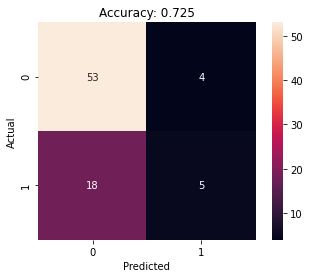

In [10]:
conf_matrix = metrics.confusion_matrix(targets, preds_bi)

plt.figure()
sns.heatmap(conf_matrix, annot=True, square=True);
plt.ylabel('Actual');
plt.xlabel('Predicted');
title = 'Accuracy: {0}'.format(accuracy)
plt.title(title);

The confusion matrix shows that the model captured most rejections correctly. However, it had 18 false negatives. There are less false positives than false negatives. In this case, a false positive is more costly than a false negative. From a student's perspective, he or she might expect to get into a target school based on a false positive prediction. A false positive will lead to serious consequences, such as mismatching oneself to schools that are impossible to get in. However, a false negative does not hurt as much. The student may consider the school to be a reach school, but still apply to it and have other backup schools at the same time.

## 3b
Discuss how different variables affect the probability of the outcome.  What are your recommendations based on your results?

The accuracy of the model achieved on the test set is 72.5%. The R-squared is low which might suggest that some other factors could be included to better explain the chance of admission. The p-value for GPA indicates significance, but p-value for GRE does not if the threshold is 0.05. The school rank is also significant. 

The impact of GRE score being very low is unexpected. The positive coefficient of GPA meets my expectation. The chance of acceptance is higher for higher GPA. Moreover, from the results, the school rank which is used as categorical data shows that its numerical value inversely relates to the chance of acceptance. 

Intuitively, there are many other factors that affect admission results. Factors like projects, research experience, recommandation letters, and past internships are all important. Missing data of these information might lead to the low R-squared.

My recommendation from this model is that looking at the GPA and school rank which are statistically significant would be useful. Furthermore, it would be helpful to collect some other data and introduce new variables to see if R-squared can be improved.

## 3c
Estimate the marginal effects and discuss the implications.

In [11]:
marginal = logit_estimates.get_margeff(at = "overall", method = "dydx")
print(marginal.summary())

        Logit Marginal Effects       
Dep. Variable:                  admit
Method:                          dydx
At:                           overall
                  dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
C(rank)[T.2]    -0.1363      0.066     -2.065      0.039      -0.266      -0.007
C(rank)[T.3]    -0.2753      0.070     -3.921      0.000      -0.413      -0.138
C(rank)[T.4]    -0.3113      0.087     -3.572      0.000      -0.482      -0.140
gpa              0.1527      0.070      2.176      0.030       0.015       0.290
gre              0.0004      0.000      1.749      0.080   -4.94e-05       0.001


The estimated marginal effects confirm the observations made before. 

GPA and school rank are significant since their p-values are less than 0.05. 

To interpret the results shown above, dy/dx of GPA means that increasing a unit in GPA will lead to an increase of about 15.27% chance to be admitted. Besides, dy/dx for school rank suggests that, for lower school ranks which are indicated by larger numerical values will lead to decreases in the chance of admission.